<font size=8> F-I curve test

In [28]:
#Common Python Packages
from pickle import TRUE
import time
import sys
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.getcwd() + '/..')

#dynapse2 spikegen imports
from lib.dynapse2_util import *
from lib.dynapse2_network import Network
from lib.dynapse2_spikegen import send_events,get_fpga_time, send_virtual_events, poisson_gen, isi_gen,regular_gen
from lib.dynapse2_raster import *
from lib.dynapse2_obj import *

#Statistics imports
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy.signal import butter, filtfilt
from sklearn.linear_model import LinearRegression

#my imports
from adaptation import pc_single,ff
from adaptation_lib.spike_stats import *
from adaptation_lib.dynapse_setup import *
from adaptation_lib.graphing import *
from adaptation_lib.tc_extraction import *
from configs import neuron_configs_bio

# Determine the user's home directory
home_directory = os.path.expanduser("~")
# Path to the Documents directory
documents_path = os.path.join(home_directory, "Documents")
# Path to the dynapse-se2-data directory within Documents
save_directory_path = os.path.join(documents_path, "dynapse-se2-data")
# Path to the data
data_type_path = os.path.join(save_directory_path, "FF")


<font size=6>Visualize Data

In [30]:
# Load your data
neuron_config=neuron_configs_bio.config()
FF_output = np.load(data_type_path+'/FF_output_1.npy', allow_pickle=True)


In [31]:
print(FF_output)

[array([  0,  17,  35,  53,  71,  89, 107, 125, 142, 160, 178, 196, 214,
        232, 250])
 list([[0, 0, 0, 22, 30, 37, 44, 50, 52, 55, 56, 57, 58, 58, 59], [0, 0, 0, 27, 38, 47, 54, 58, 59, 61, 62, 64, 63, 64, 65], [0, 0, 0, 23, 31, 38, 43, 46, 48, 49, 50, 50, 51, 52, 52], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 26, 34, 42, 49, 53, 55, 57, 58, 59, 59, 60, 60], [0, 0, 0, 25, 33, 42, 49, 54, 56, 58, 60, 60, 62, 62, 62], [0, 0, 0, 23, 32, 40, 46, 50, 51, 53, 54, 54, 55, 55, 56], [0, 0, 0, 27, 37, 46, 52, 56, 57, 60, 60, 61, 61, 61, 62], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 24, 32, 40, 46, 52, 54, 57, 59, 60, 60, 61, 61], [0, 0, 0, 25, 36, 45, 51, 56, 59, 61, 62, 62, 63, 64, 64], [0, 0, 8, 23, 31, 39, 46, 52, 55, 57, 59, 60, 60, 61, 61], [0, 0, 0, 23, 31, 38, 46, 51, 54, 57, 59, 60, 60, 62, 62], [0, 0, 0, 24, 30, 37, 44, 50, 53, 55, 57, 58, 59, 59, 60], [0, 0, 0, 22, 30, 37, 44, 48, 52, 54, 55, 56, 56, 57

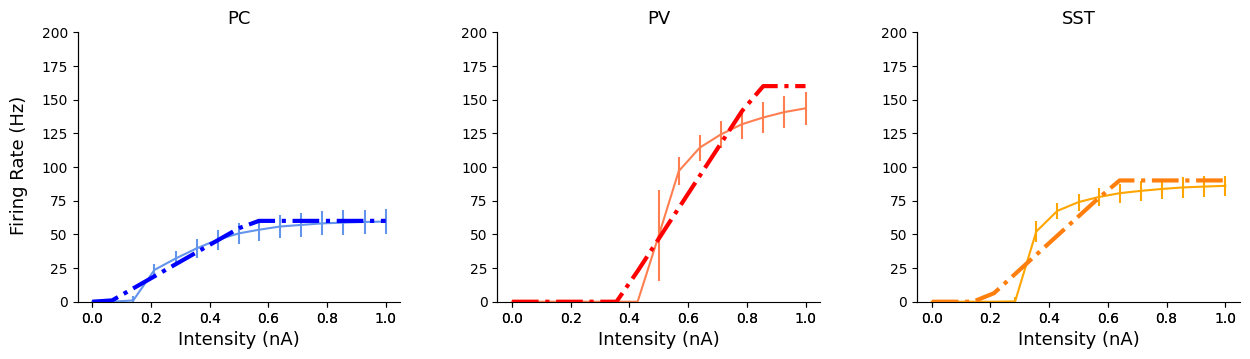

In [32]:
[FF_in, FF_out_PC, FF_out_PV, FF_out_SST, FF_cv] = FF_output

max_val = 1
font_size=13

window=len(FF_in)
means_PC = np.mean(FF_out_PC, axis=0)[:window]
stds_PC = np.std(FF_out_PC, axis=0)[:window]
means_PV = np.mean(FF_out_PV, axis=0)[:window]
stds_PV = np.std(FF_out_PV, axis=0)[:window]
means_SST = np.mean(FF_out_SST, axis=0)[:window]
stds_SST = np.std(FF_out_SST, axis=0)[:window]
FF_in = FF_in[:window]

# Normalize FF_in with your desired max_value (e.g., 200/250)
normalized_FF_in = normalize_input(FF_in, max_value=max_val)

# Calculate the fitted values
fit_PC = custom_relu((normalized_FF_in),.06,124,60) #threshold, gain, maximum firing rate
fit_PV = custom_relu((normalized_FF_in),.36,334,160)
fit_SST = custom_relu((normalized_FF_in),.18,198,90)

# Compute residuals
residuals_PC = means_PC - fit_PC
residuals_PV = means_PV - fit_PV
residuals_SST = means_SST - fit_SST

# Calculate root-mean-square error rounded to 2 decimal places

rmse_PC = np.sqrt(np.mean(residuals_PC**2))
rmse_PV = np.sqrt(np.mean(residuals_PV**2))
rmse_SST = np.sqrt(np.mean(residuals_SST**2))


fig, axs = plt.subplots(1, 3, figsize=(15, 3.5))

# Data
data = [
    (means_PC, stds_PC, fit_PC, rmse_PC, 'cornflowerblue', 'b-.'),
    (means_PV, stds_PV, fit_PV, rmse_PV, 'coral', 'r-.'),
    (means_SST, stds_SST, fit_SST, rmse_SST, '#FFA500',  'C1-.')
]

labels = ["PC", "PV", "SST"]

for i, ax in enumerate(axs):
    means, stds, fit, rmse, color, fit_color = data[i]
    label = labels[i]

    # Plot with error bars vs input DC parameter
    ax.errorbar(normalized_FF_in, means, yerr=stds, c=color, label=f'{label} dynapse')

    ax.set_title(f'{label}', fontsize=font_size)
    ax.set_xlabel(f'Intensity (nA)', fontsize=font_size)

    # Plot the fitted curves
    ax2 = ax.twiny()
    ax2.plot(normalized_FF_in, fit, fit_color, label=f'{label} bio fit', linewidth=3)
    ax2.set_ylim(0, 200)

    # Offset the twin axis below the host
    ax2.spines["bottom"].set_visible(False)

    # Remove right and top borders
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)

    #ax2.set_xlabel('Input Pulse normalized')

    # Move twinned axis ticks and label from top to bottom
    ax2.xaxis.set_ticks_position("bottom")
    ax2.xaxis.set_label_position("bottom")

    # Legend
    #ax2.legend(bbox_to_anchor=(.5, 1), loc='upper right', fontsize=font_size)
plt.subplots_adjust(wspace=0.3)  # Adjust the width space as needed

    # Create input annotation with rmse errors rounded to two decimal places
fig.text(0.08, 0.5, 'Firing Rate (Hz)', va='center', rotation='vertical', fontsize=font_size)

#plt.tight_layout()
plt.show()


In [33]:
print(normalized_FF_in)

[0.    0.068 0.14  0.212 0.284 0.356 0.428 0.5   0.568 0.64  0.712 0.784
 0.856 0.928 1.   ]


In [21]:
np.size(FF_out_PC, axis=0)

NameError: name 'FF_out_PC' is not defined

In [22]:
import numpy as np
import pandas as pd
from scipy import stats

# Load the numpy file
data_path = 'f_i_data.npy'  # Update the path if the file is in a different directory
data = np.load(data_path, allow_pickle=True)

# Extract the data for each group
data_item = data.item()
data_pc = np.array(data_item['FF_out_PC'])
data_pv = np.array(data_item['FF_out_PV'])
data_sst = np.array(data_item['FF_out_SST'])

# Perform One-Way ANOVA for each of the 15 measurements across the three groups
anova_results = []

for i in range(15):
    # Extract the data for the i-th measurement across all samples
    sample_pc = data_pc[:, i]
    sample_pv = data_pv[:, i]
    sample_sst = data_sst[:, i]

    # Perform the ANOVA
    f_stat, p_value = stats.f_oneway(sample_pc, sample_pv, sample_sst)

    # Append the results
    anova_results.append({
        'Measurement': i + 1,  # Measurement number (starting from 1)
        'F-Statistic': f_stat,
        'p-Value': p_value
    })

# Create a DataFrame to hold the results and handle NaN values
anova_results_df = pd.DataFrame(anova_results).fillna('Not Computable')

# Display the results
print(anova_results_df)


    Measurement     F-Statistic         p-Value
0             1  Not Computable  Not Computable
1             2  Not Computable  Not Computable
2             3       26.997096             0.0
3             4     7326.776492             0.0
4             5     5727.406134             0.0
5             6     4694.257797             0.0
6             7     9014.300692             0.0
7             8      114.878956             0.0
8             9       1264.2078             0.0
9            10     2025.370524             0.0
10           11      2417.37679             0.0
11           12     2667.803459             0.0
12           13     2852.814406             0.0
13           14     2980.281836             0.0
14           15     3056.282054             0.0


/home/hector/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:3895: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


In [19]:
import numpy as np
import pandas as pd
from statsmodels.stats.anova import AnovaRM

# Load the data
data_path = 'f_i_data.npy'
data = np.load(data_path, allow_pickle=True)

# Extract the data for each group
data_item = data.item()
data_pc = np.array(data_item['FF_out_PC'])
data_pv = np.array(data_item['FF_out_PV'])
data_sst = np.array(data_item['FF_out_SST'])

# Create a DataFrame with all the data
df_long = pd.DataFrame({
    'Subject': np.tile(np.repeat(np.arange(1, 251), 15), 3),  # 250 subjects, 15 measurements each, repeated for 3 groups
    'Group': np.repeat(['PC', 'PV', 'SST'], 250 * 15),
    'Measurement': np.tile(np.arange(1, 16), 250 * 3),
    'Value': np.concatenate([data_pc.flatten(), data_pv.flatten(), data_sst.flatten()])
})

# Perform the mixed two-way ANOVA
aovrm2way = AnovaRM(df_long, 'Value', 'Subject', within=['Measurement'], between='Group')
res2way = aovrm2way.fit()

print(res2way)


NotImplementedError: Between subject effect not yet supported!

In [22]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Load the data
data = f_i_data

# Prepare the long-format DataFrame
intensities = np.array([0, 17, 35, 53, 71, 89, 107, 125, 142, 160, 178, 196, 214, 232, 250])
df_long = pd.DataFrame({
    'CellType': np.repeat(['PC', 'PV', 'SST'], repeats=250*15),
    'Intensity': np.tile(np.repeat(intensities, 250), 3),
    'Value': np.concatenate([data['FF_out_PC'].flatten(), data['FF_out_PV'].flatten(), data['FF_out_SST'].flatten()])
})

# Fit a mixed-effects model
model = smf.mixedlm("Value ~ C(CellType) * C(Intensity)", df_long, groups=df_long['CellType'])
result = model.fit()

# Print the summary of the model
print(result.summary())


AttributeError: 'list' object has no attribute 'flatten'